In [ ]:
# -*- coding: utf-8 -*-
# -*- author: Yaping Mo -*-

In [ ]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from joblib import dump, load
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
class Dataset:
    def __init__(self, in_file):
        self.in_file = in_file  # Tiff或者ENVI文件

        dataset = gdal.Open(self.in_file)
        self.XSize = dataset.RasterXSize  # 网格的X轴像素数量
        self.YSize = dataset.RasterYSize  # 网格的Y轴像素数量
        self.RasterNum = dataset.RasterCount  # 波段数
        self.GeoTransform = dataset.GetGeoTransform()  # 投影转换信息
        self.ProjectionInfo = dataset.GetProjection()  # 投影信息

    def get_data(self, band):
        """
        get single band data
        """
        dataset = gdal.Open(self.in_file)
        band = dataset.GetRasterBand(band)
        data = band.ReadAsArray()
        return data

    def get_lon_lat(self):
        """
        get geographical information
        """
        gtf = self.GeoTransform
        x_range = range(0, self.XSize)
        y_range = range(0, self.YSize)
        x, y = np.meshgrid(x_range, y_range)
        lon = gtf[0] + x * gtf[1] + y * gtf[2]
        lat = gtf[3] + x * gtf[4] + y * gtf[5]
        return lon, lat

    def to_df(self):
        """
        reformat data and transform to dataframe
        """
        longitude, latitude = dataset.get_lon_lat()
        df = pd.DataFrame(longitude.flatten(), columns=['X'])
        df.insert(1, 'Y', pd.DataFrame(latitude.flatten(), columns=['Y']))
        for i in range(1, self.RasterNum+1, 1):
          data = dataset.get_data(i)
          df.insert(i+1, 'b'+str(i), pd.DataFrame(data.flatten(), columns=['b'+str(i)]))
        # reformat lon, lat
        df['X'] = round(df['X'].astype('float'), 2)
        df['Y'] = round(df['Y'].astype('float'), 2)
        return df

In [ ]:
def split_Xy(feature, roi):
  """
  create dataset of X and y
  """
  df = pd.merge(feature, roi, how='inner',on=["X","Y"]).drop(['X', 'Y', 'ClassName'], axis=1)
  X = df.drop('Class', axis=1)
  y = df['Class']
  return X,y

In [ ]:
# model fit

def fit_model(input_X, input_y, input_parameters, input_model, out_model, out_matrix, out_details):
  """
  input_X, input_y:independent and dependent variables
  input_parameters:fit the model with different parameters
  out_model:path of the best model
  out_matrix:path of the confusion matrix
  out_txt:path of txt file for fitting details
  """
  switch = {"random forest":RandomForestClassifier,"svm":svm.SVC,"knn":KNeighborsClassifier, "logistic regression":LogisticRegression}
  start =time.process_time()
  # search the best estimator
  grid = GridSearchCV(estimator=switch[input_model](), param_grid=input_parameters, cv=5, verbose=2)
  grid.fit(input_X, input_y)
  end = time.process_time()
  # calculate the confusion matrix
  y_predict = grid.predict(input_X)
  matrix = pd.DataFrame(confusion_matrix(y, y_predict))
  matrix.columns = roi['ClassName'].unique()
  matrix.index = roi['ClassName'].unique()
  matrix.to_csv(out_matrix)
  # save the best estimator
  model = grid.best_estimator_
  dump(model, out_model)  # modelRF = load('/content/drive/MyDrive/classify/rf/model/rf.joblib') 
  # save the details
  df = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
  df.to_csv(out_details)
  return model

In [ ]:
# prediction
def get_predict(input_data, input_X, input_model, input_mask, output_img, output_img_masked):
  """
  input_data:feature image
  input_X:X to be predicted
  input_model:model used to predict
  input_mask:image used to mask
  output_img:path of the output geotiff
  output_img_masked:path of the masked output
  """
  start =time.process_time()
  predictLabels = input_model.predict(input_X)
  end = time.process_time()
  result = predictLabels.reshape(input_data.YSize,input_data.XSize)
  result = result.astype(np.uint8)
  print(f'Prediction Time: {(end-start):.0f} seconds')
  create_geotiff(input_data, result, output_img)
  result_masked = np.array(predictLabels*input_mask['Value'])
  result_masked = result_masked.reshape(input_data.YSize,input_data.XSize)
  result_masked = result_masked.astype(np.uint8)
  create_geotiff(input_data, result_masked, output_img_masked)


def create_geotiff(input_data, input_array, output_img):
  """
  input_data:feature image
  input_array:array to geotiff
  output_img:path of the output geotiff
  """
  driver = gdal.GetDriverByName("GTiff")
  geotiff = driver.Create(output_img, input_data.XSize, input_data.YSize, 1, gdal.GDT_Byte) 
  geotiff.SetGeoTransform = input_data.GeoTransform
  geotiff.SetProjection = input_data.ProjectionInfo
  geotiff.GetRasterBand(1).WriteArray(input_array)
  geotiff.FlushCache()
  geotiff = None # !!!!necessary

# Data preparation

In [ ]:
# read feature image (X&Y for matching)
dataset = Dataset('/content/drive/MyDrive/classify/dataset/Image.dat')
imgXY = dataset.to_df()
imgXY = imgXY.apply(lambda x: x.fillna(x.mean()))  # replace NA value with the mean of column
# create array for model.predict
img = imgXY.drop(['X', 'Y'], axis=1)

imgXY.head(3)

,X,Y,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29
0,547201.1,4311890.5,0.0,0.0,-11421.861328,-5452.348633,-184.151337,464.515137,264.149384,208.155884,132.075638,-265.978302,-82.831078,-348.965057,80.128067,-94.210571,-97.115784,-29.867931,110.786217,132.611816,37.724239,-110.127136,7.110601,-49.673630,-42.686401,-58.087135,-99.512253,79.189774,8.231567,0.102372,-0.036543
1,547201.6,4311890.5,0.0,0.0,-10870.431641,-4897.838379,78.436523,623.520447,338.624969,137.935684,347.557434,-281.429230,-85.459312,-305.288055,147.815598,-37.045937,-29.172604,-15.660460,13.629247,34.297775,-49.913746,-50.137657,25.826109,-30.130619,-63.167614,-28.288338,-15.181405,55.468647,-12.434270,0.099902,0.004293
2,547202.1,4311890.5,0.0,0.0,-8810.846680,-5156.060059,424.062561,364.486969,192.780273,299.465912,475.790802,-285.268982,-227.152573,-275.468384,179.767731,-84.628571,-45.889946,-4.495757,57.921883,-63.216152,-126.463112,-62.799694,5.401490,-4.081057,-62.417614,-19.853701,-3.913828,90.749786,22.241161,0.073006,0.055016


In [ ]:
# read mask image (X&Y for matching)
dataset_mask = Dataset('/content/drive/MyDrive/classify/dataset/Mask.dat')
# use to_df() function will cause the datatype of mask result???
# mask = dataset_mask.to_df()
mask = pd.DataFrame(dataset_mask.get_data(1).flatten(), columns=['Value'])
mask.groupby(by='Value').size()

Value
0    2247890
1    3677110
dtype: int64

In [ ]:
# read roi
roi = pd.read_csv("/content/drive/MyDrive/classify/dataset/roi.csv", encoding="utf-8", usecols=['X', 'Y', 'Class', 'ClassName'])
X,y = split_Xy(imgXY, roi)  # get independent and dependent variables
y.head(3)

0    20
1    20
2    20
Name: Class, dtype: int64

In [ ]:
roi = pd.read_csv("/content/drive/MyDrive/classify/dataset/roi.csv", encoding="utf-8", usecols=['X', 'Y', 'Class', 'ClassName'])
df = pd.merge(imgXY, roi, how='inner',on=["X","Y"]).drop(['X', 'Y', 'ClassName'], axis=1)
df.to_csv('/content/drive/MyDrive/classify/dataset/roiFeature.csv')

# Model fit

In [ ]:
# random forest
# first is default value in RandomForestClassifier
# ref:https://www.cnblogs.com/pinard/p/6160412.html;https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#
parametersRF = {
    'n_estimators':[50, 80],
    'max_depth':[None, 10],
    'min_samples_split':[2, 4],
    'min_samples_leaf':[1, 2],
    'class_weight':[None, 'balanced', 'balanced_subsample']
    }
modelRF = fit_model(X, y, parametersRF, 'random forest',
                 '/content/drive/MyDrive/classify/result/modelRF.joblib', 
                 '/content/drive/MyDrive/classify/result/confusionMatrixRF.csv', 
                 '/content/drive/MyDrive/classify/result/detailsRF.txt')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   6.0s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   6.1s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   6.0s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   6.0s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   6.0s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   9.5s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   9.6s
[CV] max_depth=None, min_samples_leaf=1, 

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  8.7min finished


In [ ]:
# svm
# rbf kernel:short fit time, but long prediction time and poor accuracy.
# linear kernel:short prediction time and good accuracy, but long fit time.
# first is default value in LinearSVC
# ref:https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
parametersSVM = {
    'C':[1, 10],
    'kernel':['rbf', 'sigmoid', 'poly', 'linear']
    }
modelSVM = fit_model(X, y, parametersSVM, 'svm',
                 '/content/drive/MyDrive/classify/result/modelSVM.joblib', 
                 '/content/drive/MyDrive/classify/result/confusionMatrixSVM.csv', 
                 '/content/drive/MyDrive/classify/result/detailsSVM.txt')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=1, kernel=rbf .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. C=1, kernel=rbf, total=  15.7s
[CV] C=1, kernel=rbf .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


[CV] .................................. C=1, kernel=rbf, total=  16.0s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=  15.8s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=  15.6s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=  14.8s
[CV] C=1, kernel=sigmoid .............................................
[CV] .............................. C=1, kernel=sigmoid, total=  21.7s
[CV] C=1, kernel=sigmoid .............................................
[CV] .............................. C=1, kernel=sigmoid, total=  22.3s
[CV] C=1, kernel=sigmoid .............................................
[CV] .............................. C=1, kernel=sigmoid, total=  22.9s
[CV] C=1, kernel=sigmoid .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.3min finished


In [ ]:
# knn
# first is default value in LinearSVC
# ref:https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier
parametersKNN = {
    'n_neighbors':[5, 7, 9],
    'weights':['uniform', 'distance']
    }
modelKNN = fit_model(X, y, parametersKNN, 'knn',
                 '/content/drive/MyDrive/classify/result/modelKNN.joblib', 
                 '/content/drive/MyDrive/classify/result/confusionMatrixKNN.csv', 
                 '/content/drive/MyDrive/classify/result/detailsKNN.csv')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... n_neighbors=5, weights=uniform, total=   0.3s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................... n_neighbors=5, weights=uniform, total=   0.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.3s
[CV] n_neighbors=5, weights=distance .................................
[CV] .................. n_neighbors=5, weights=distance, total=   0.2s
[CV] n_neighbors=5, weights=distance .................................
[CV] .................. n_neighbors=5, weights=distance, total=   0.2s
[CV] n_neighbors=5, weights=distance .................................
[CV] .................. n_neighbors=5, weights=distance, total=   0.2s
[CV] n_neighbors=5, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.1s finished


In [ ]:
# logistic regression
# first is default value in LinearSVC
# ref:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression
parametersLR = {
    'C':[1, 3, 5],
    'class_weight':[None, 'balanced']
    }
modelLR = fit_model(X, y, parametersLR, 'logistic regression',
                 '/content/drive/MyDrive/classify/result/model/modelLR.joblib', 
                 '/content/drive/MyDrive/classify/result/confusionMatrixLR.csv', 
                 '/content/drive/MyDrive/classify/result/detailsLR.txt')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] .............................................. C=1, total=   4.5s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=1, total=   4.3s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=1, total=   4.2s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=1, total=   4.3s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=1, total=   4.2s
[CV] C=3 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=3, total=   4.3s
[CV] C=3 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=3, total=   4.3s
[CV] C=3 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=3, total=   4.2s
[CV] C=3 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=3, total=   4.2s
[CV] C=3 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=3, total=   4.3s
[CV] C=5 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=5, total=   4.3s
[CV] C=5 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=5, total=   4.3s
[CV] C=5 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=5, total=   4.2s
[CV] C=5 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................................. C=5, total=   4.2s
[CV] C=5 .............................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.1min finished


[CV] .............................................. C=5, total=   4.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Prediction

In [ ]:
modelRF = load('/content/drive/MyDrive/classify/result/modelRF.joblib') 
get_predict(dataset, img, modelRF, mask, '/content/drive/MyDrive/classify/result/rf.tif', '/content/drive/MyDrive/classify/result/rf_masked.tif')

Prediction Time: 123 seconds


In [ ]:
modelSVM = load('/content/drive/MyDrive/classify/result/modelSVM.joblib') 
get_predict(dataset, img, modelSVM, mask, '/content/drive/MyDrive/classify/result/svm.tif', '/content/drive/MyDrive/classify/result/svm_masked.tif')

Prediction Time: 6398 seconds


In [ ]:
modelKNN = load('/content/drive/MyDrive/classify/result/modelKNN.joblib') 
get_predict(dataset, img, modelKNN, mask, '/content/drive/MyDrive/classify/result/knn.tif', '/content/drive/MyDrive/classify/result/knn_masked.tif')

Prediction Time: 197 seconds


In [ ]:
modelLR = load('/content/drive/MyDrive/classify/result/modelLR.joblib')
get_predict(dataset, img, modelLR, mask,
            '/content/drive/MyDrive/classify/result/lr.tif', '/content/drive/MyDrive/classify/result/lr_masked.tif')

Prediction Time: 4 seconds


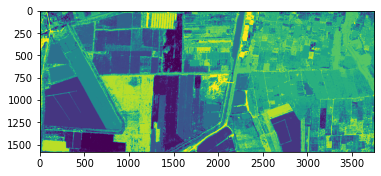

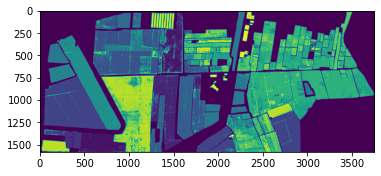

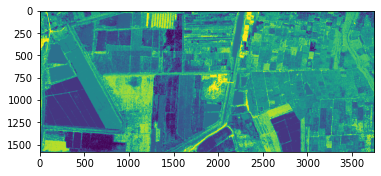

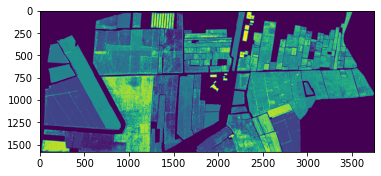

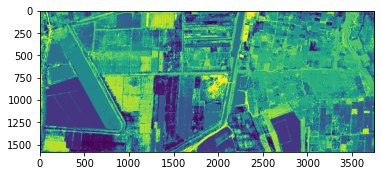

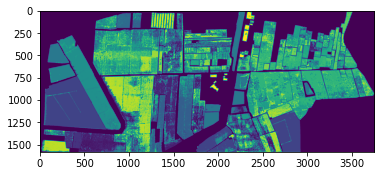

In [ ]:
imRF = plt.imread('/content/drive/MyDrive/classify/result/rf.tif')
imRF_masked = plt.imread('/content/drive/MyDrive/classify/result/rf_masked.tif')
imSVM = plt.imread('/content/drive/MyDrive/classify/result/svm.tif')
imSVM_masked = plt.imread('/content/drive/MyDrive/classify/result/svm_masked.tif')
imKNN = plt.imread('/content/drive/MyDrive/classify/result/knn.tif')
imKNN_masked = plt.imread('/content/drive/MyDrive/classify/result/knn_masked.tif')
imLR = plt.imread('/content/drive/MyDrive/classify/result/lr.tif')
imLR_masked = plt.imread('/content/drive/MyDrive/classify/result/lr_masked.tif')
images = [imRF, imRF_masked, imKNN, imKNN_masked, imLR, imLR_masked]
for ima in images:
    plt.figure()
    plt.imshow(ima)